In [1]:
import os
import torch
import matplotlib.pyplot as plt
from phase_space_reconstruction.virtual.beamlines import sextupole_drift
from phase_space_reconstruction.virtual.scans import run_sextupole_scan
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from phase_space_reconstruction.train import train_1d_scan_sext

from bmadx.plot import plot_projections
from phase_space_reconstruction.visualization import plot_scan_data, plot_predicted_screens

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
data_dir = 'data'

In [3]:
gt_beam = torch.load("../synthetic_6d/data/gaussian_beam.pt")

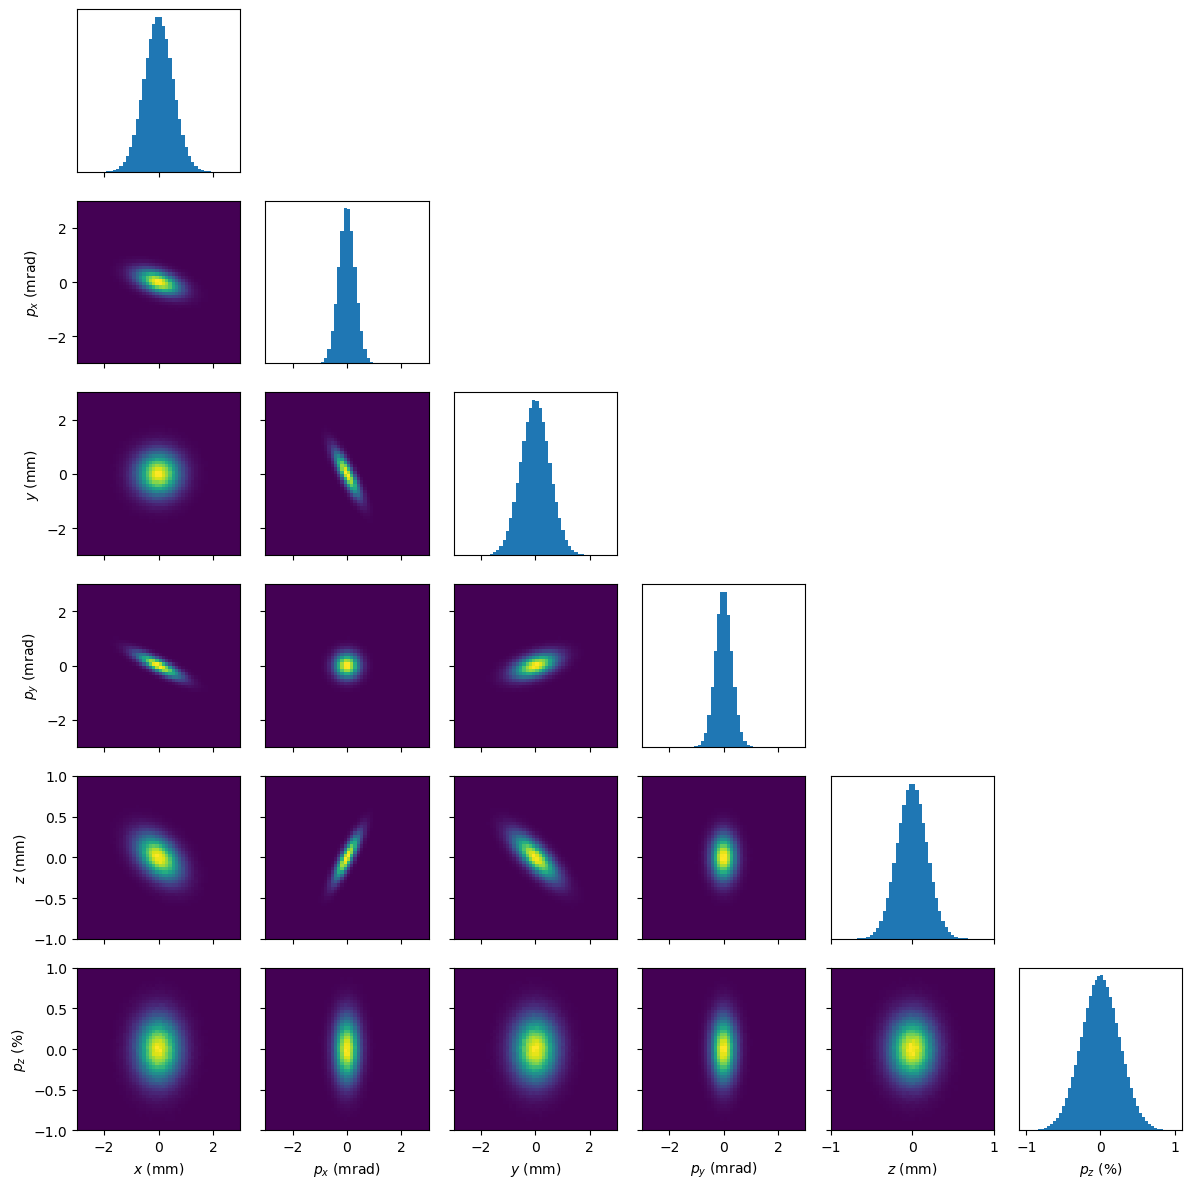

In [4]:
#plot gt beam
import numpy as np
lims = np.array([[-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-5e-3, 5e-3],
                 [-5e-2, 5e-2]]) *0.2
fig, ax = plot_projections(
    gt_beam.numpy_particles(),
    custom_lims = lims,
    background = 0
)
plt.show()

In [5]:
# diagnostic beamline:
lattice = sextupole_drift()

# design momentum (eV)
p0c = 10.0e6

# quadrupole strengths for scan (reshape as: n_quad_strengths x n_images_per_quad_strength x 1)
n_ks = 10
ks = torch.linspace(-100, 100, n_ks).reshape((n_ks,1,1))*50

# split in training and testing sets
train_ks = ks[::2]
test_ks = ks[1::2]

# create diagnostic screen: 
bins = torch.linspace(-5, 5, 200) * 1e-3
bandwidth = (bins[1]-bins[0]) / 2
screen = ImageDiagnostic(bins, bins, bandwidth)

In [6]:
# generate and save train and test datasets
train_dset = run_sextupole_scan(gt_beam, lattice, screen, train_ks, save_as=os.path.join('data',
                                                                        'train.dset'))
test_dset = run_sextupole_scan(gt_beam, lattice, screen, test_ks, save_as=os.path.join('data', 'test'
                                                                              '.dset'))

[('elements.0.L', Parameter containing:
tensor(0.1000)), ('elements.0.X_OFFSET', Parameter containing:
tensor(0.)), ('elements.0.Y_OFFSET', Parameter containing:
tensor(0.)), ('elements.0.NUM_STEPS', Parameter containing:
tensor(5)), ('elements.0.TILT', Parameter containing:
tensor(0.)), ('elements.0.K2', Parameter containing:
tensor([[[-5000.0000]],

        [[-2777.7778]],

        [[ -555.5557]],

        [[ 1666.6667]],

        [[ 3888.8889]]])), ('elements.1.L', Parameter containing:
tensor(1.))]
dataset saved as 'data/train.dset'
[('elements.0.L', Parameter containing:
tensor(0.1000)), ('elements.0.X_OFFSET', Parameter containing:
tensor(0.)), ('elements.0.Y_OFFSET', Parameter containing:
tensor(0.)), ('elements.0.NUM_STEPS', Parameter containing:
tensor(5)), ('elements.0.TILT', Parameter containing:
tensor(0.)), ('elements.0.K2', Parameter containing:
tensor([[[-3888.8889]],

        [[-1666.6667]],

        [[  555.5557]],

        [[ 2777.7778]],

        [[ 5000.0000]]])), (

image size = 10 x 10 mm
test samples boxed in orange


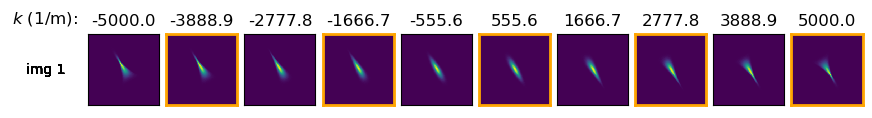

In [7]:
# plot generated datasets
fig, ax = plot_scan_data(train_dset, test_dset, bins, bins)
plt.show()

In [8]:
# training
pred_beam = train_1d_scan_sext(
    train_dset, 
    lattice, 
    p0c, 
    screen, 
    n_epochs=3000,
    device='cuda',
    save_dir=".",
    distribution_dump_n_particles=1_000_000,
)

Using device: cuda
0 tensor(4.8912e-05, device='cuda:0', grad_fn=<MeanBackward0>)
100 tensor(5.1110e-06, device='cuda:0', grad_fn=<MeanBackward0>)
200 tensor(4.9959e-06, device='cuda:0', grad_fn=<MeanBackward0>)
300 tensor(4.8308e-06, device='cuda:0', grad_fn=<MeanBackward0>)
400 tensor(4.7512e-06, device='cuda:0', grad_fn=<MeanBackward0>)
500 tensor(4.7305e-06, device='cuda:0', grad_fn=<MeanBackward0>)
600 tensor(5.3347e-06, device='cuda:0', grad_fn=<MeanBackward0>)
700 tensor(5.4680e-06, device='cuda:0', grad_fn=<MeanBackward0>)
800 tensor(5.0981e-06, device='cuda:0', grad_fn=<MeanBackward0>)
900 tensor(4.1827e-06, device='cuda:0', grad_fn=<MeanBackward0>)
1000 tensor(4.3114e-06, device='cuda:0', grad_fn=<MeanBackward0>)
1100 tensor(4.0758e-06, device='cuda:0', grad_fn=<MeanBackward0>)
1200 tensor(4.2794e-06, device='cuda:0', grad_fn=<MeanBackward0>)
1300 tensor(5.0034e-06, device='cuda:0', grad_fn=<MeanBackward0>)
1400 tensor(4.3550e-06, device='cuda:0', grad_fn=<MeanBackward0>)
150

In [9]:
# predicted screens:
pred_dset = run_sextupole_scan(pred_beam, lattice, screen, ks)

[('elements.0.L', Parameter containing:
tensor(0.1000)), ('elements.0.X_OFFSET', Parameter containing:
tensor(0.)), ('elements.0.Y_OFFSET', Parameter containing:
tensor(0.)), ('elements.0.NUM_STEPS', Parameter containing:
tensor(5)), ('elements.0.TILT', Parameter containing:
tensor(0.)), ('elements.0.K2', Parameter containing:
tensor([[[-5000.0000]],

        [[-3888.8889]],

        [[-2777.7778]],

        [[-1666.6667]],

        [[ -555.5557]],

        [[  555.5557]],

        [[ 1666.6667]],

        [[ 2777.7778]],

        [[ 3888.8889]],

        [[ 5000.0000]]])), ('elements.1.L', Parameter containing:
tensor(1.))]


image size = 10 x 10 mm
test samples boxed in orange


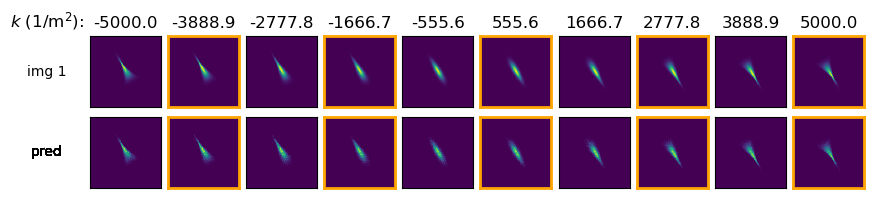

In [10]:
# compare predicted screens with data
fig, ax = plot_predicted_screens(pred_dset, train_dset, test_dset, bins, bins)
fig.savefig("sextupole_data.svg")
plt.show()

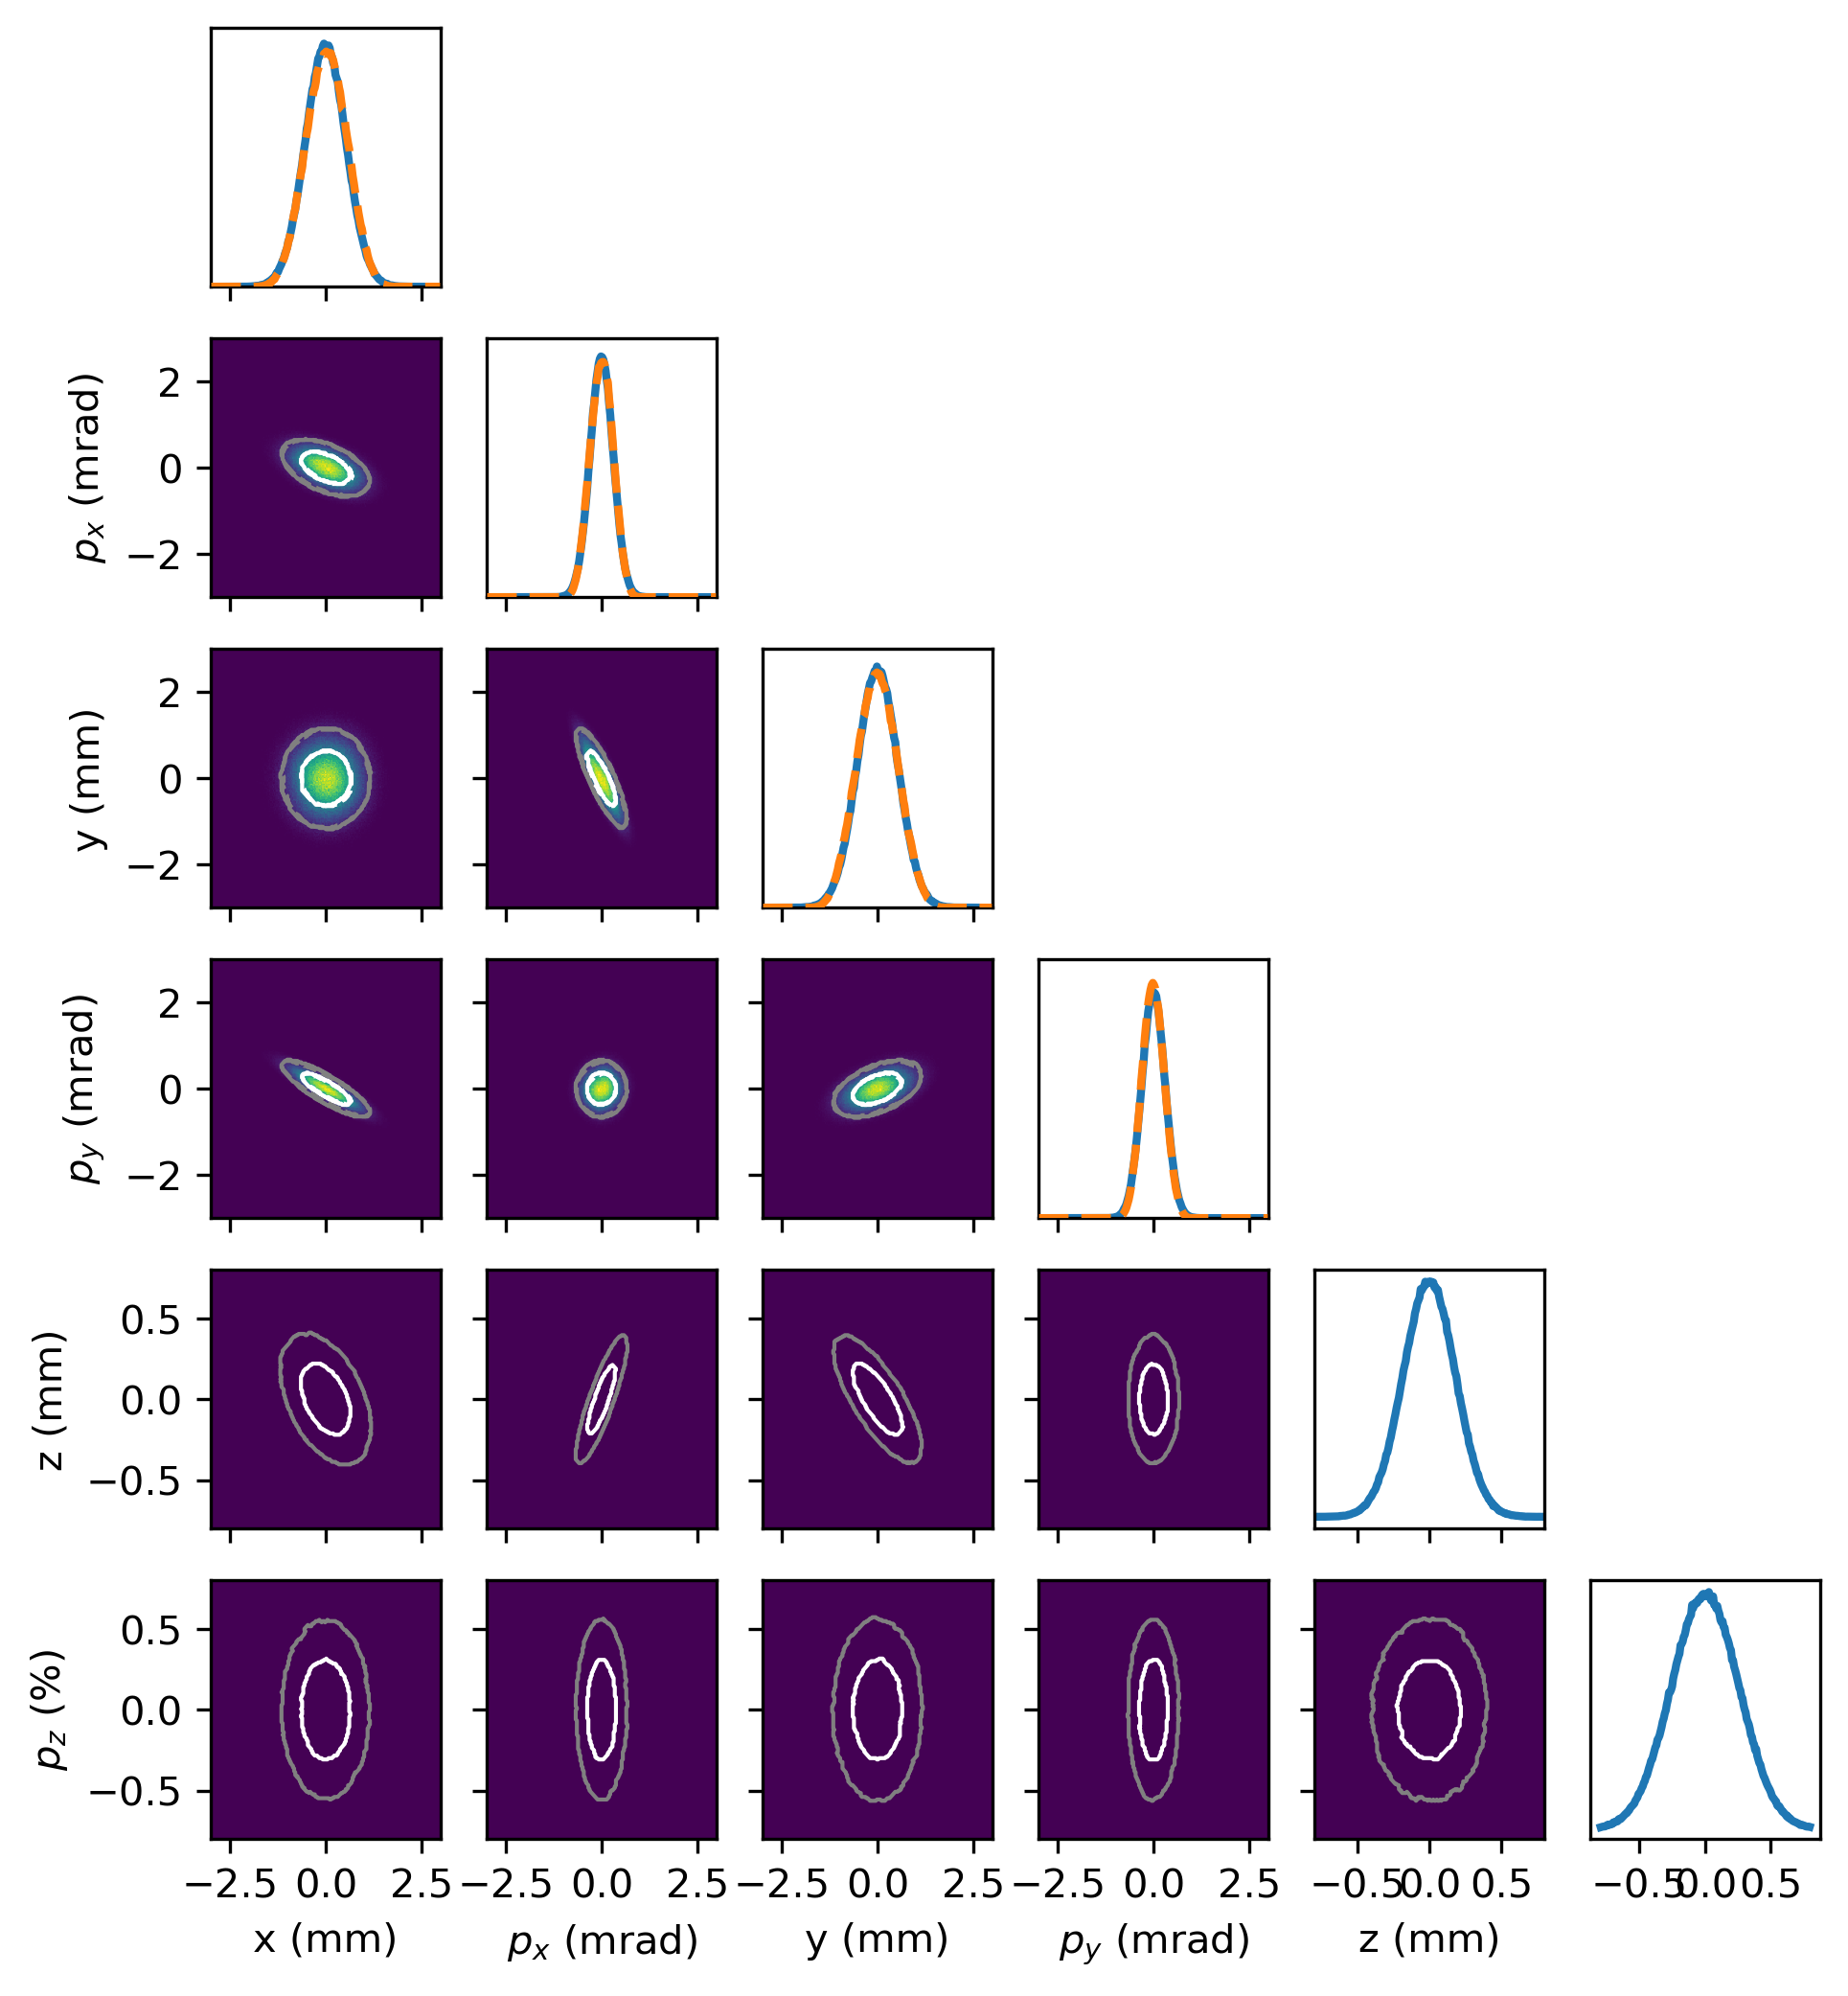

In [12]:
import sys
sys.path.append("../synthetic_6d")
from stats import plot_projections_with_contours

lims = np.array([[-15, 15],
                 [-15, 15],
                 [-15, 15],
                 [-15, 15],
                 [-4, 4],
                 [-4, 4]])*0.2 

pred_beam = torch.load("dist_3000.pt")
fig,ax = plot_projections_with_contours(
    pred_beam,
    gt_beam,
    n_bins=200,
    contour_percentiles = [50, 90],
    custom_lims=lims,
    contour_smoothing=0.25,
)
fig.set_size_inches(7,7)
fig.savefig("sextupole_reconstruction.svg")

In [ ]:
# ground truth beam projections:
fig, ax = plot_projections(gt_beam.numpy_particles(),
                           coords=('x', 'px', 'y', 'py',"z","pz"),

                           )
plt.show()

In [ ]:
torch.cuda.empty_cache()